In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import seaborn as sns 

In [3]:
# Загрузка лог-доходностей и матрицы
df_returns = pd.read_csv("df_log_returns.csv", index_col="Date", parse_dates=True)

with open("cov_matrices_rolling.pkl", "rb") as f:
    cov_matrices = pickle.load(f)

In [5]:
last_date = list(cov_matrices.keys())[-1]
cov_matrix = cov_matrices[last_date]
mean_returns = df_returns.loc[:last_date].iloc[-252:].mean() * 252  # годовые доходности

tickers = mean_returns.index
mu = mean_returns.values
Sigma = cov_matrix.values

n = len(mu)

# Целевая доходность: R_target от min до max
R_range = np.linspace(mu.min(), mu.max(), 100)
frontier_risk = []
frontier_weights = []


In [6]:
# Ограничения: сумма весов = 1, доходность = R_target
for R_target in R_range:
    # Целевая функция: дисперсия портфеля
    def portfolio_variance(w):
        return w.T @ Sigma @ w

    # Ограничения
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]
    
    # Без ограничений на short-selling
    bounds = [(None, None) for _ in range(n)]

    # Начальное приближение
    w0 = np.ones(n) / n

    result = minimize(portfolio_variance, w0, bounds=bounds, constraints=constraints)
    if result.success:
        frontier_risk.append(np.sqrt(result.fun))
        frontier_weights.append(result.x)
    else:
        frontier_risk.append(np.nan)
        frontier_weights.append(None)


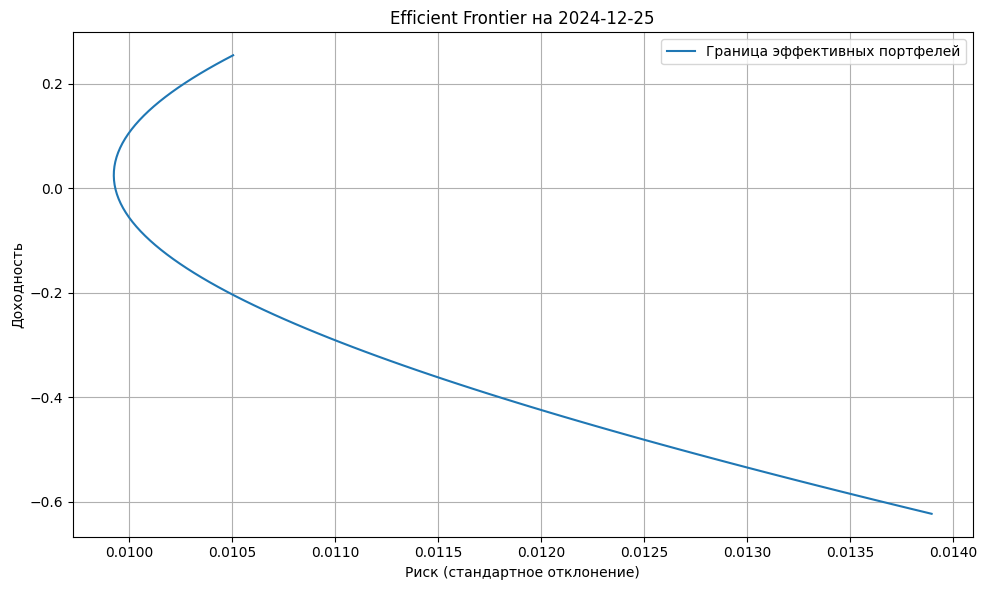

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(frontier_risk, R_range, label="Граница эффективных портфелей")
plt.xlabel("Риск (стандартное отклонение)")
plt.ylabel("Доходность")
plt.title(f"Efficient Frontier на {last_date.date()}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Граница эффективных портфелей без ограничений на short selling

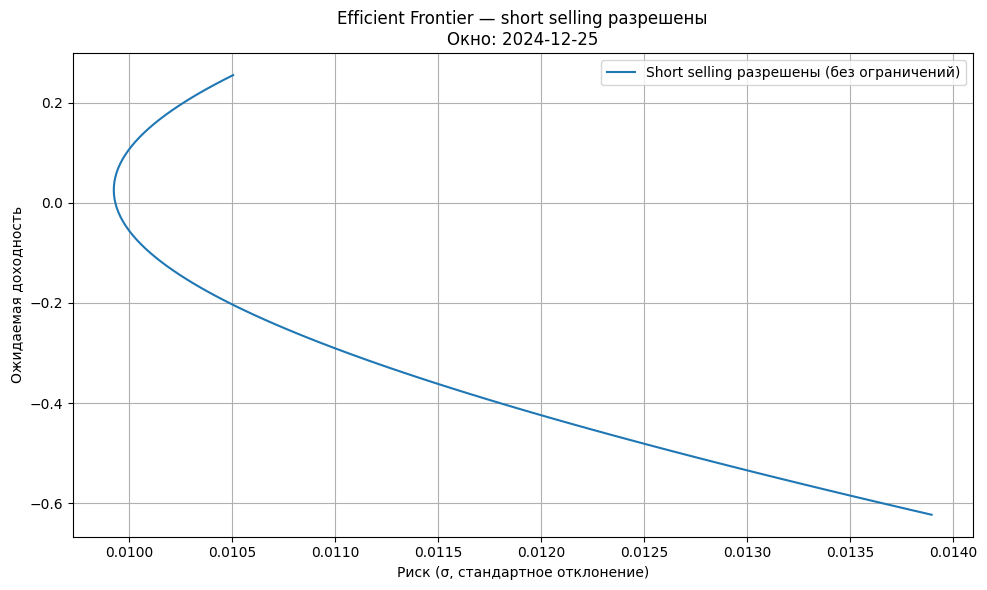

In [8]:
target_returns = np.linspace(mu.min(), mu.max(), 100)

risks = []
weights_list = []

for R_target in target_returns:
    # Целевая функция — минимизация дисперсии портфеля
    def portfolio_variance(w):
        return w.T @ Sigma @ w

    # Ограничения:
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},             # сумма весов = 1
        {"type": "eq", "fun": lambda w: w @ mu - R_target},         # заданная доходность
    ]
    
    # Без ограничений на веса (short selling разрешен)
    bounds = [(None, None) for _ in range(n)]
    
    # Начальное приближение — равномерное распределение
    w0 = np.ones(n) / n

    result = minimize(portfolio_variance, w0, method="SLSQP", bounds=bounds, constraints=constraints)

    if result.success:
        var = result.fun
        std = np.sqrt(var)
        risks.append(std)
        weights_list.append(result.x)
    else:
        risks.append(np.nan)
        weights_list.append(None)

# Визуализация границы
plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns, label="Short selling разрешены (без ограничений)")
plt.xlabel("Риск (σ, стандартное отклонение)")
plt.ylabel("Ожидаемая доходность")
plt.title(f"Efficient Frontier — short selling разрешены\nОкно: {last_date.date()}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Граница с ограничением short-selling: не более 25% капитала на бумагу

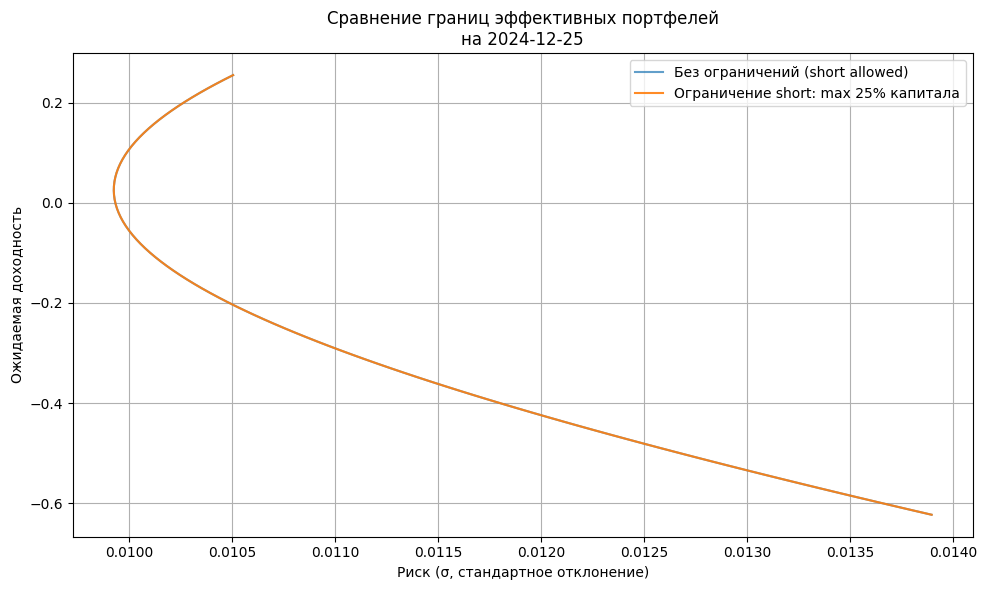

In [9]:
target_returns_limited = np.linspace(mu.min(), mu.max(), 100)

risks_limited = []
weights_limited = []

for R_target in target_returns_limited:
    def portfolio_variance(w):
        return w.T @ Sigma @ w

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]
    
    # Ограничение short selling: w_i >= -0.25
    bounds = [(-0.25, None) for _ in range(n)]  # нижняя граница -0.25, верхняя не ограничена

    w0 = np.ones(n) / n

    result = minimize(portfolio_variance, w0, method="SLSQP", bounds=bounds, constraints=constraints)

    if result.success:
        var = result.fun
        std = np.sqrt(var)
        risks_limited.append(std)
        weights_limited.append(result.x)
    else:
        risks_limited.append(np.nan)
        weights_limited.append(None)


plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns, label="Без ограничений (short allowed)", alpha=0.7)
plt.plot(risks_limited, target_returns_limited, label="Ограничение short: max 25% капитала", alpha=0.9)
plt.xlabel("Риск (σ, стандартное отклонение)")
plt.ylabel("Ожидаемая доходность")
plt.title(f"Сравнение границ эффективных портфелей\nна {last_date.date()}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Граница эффективных портфелей при запрете на short selling

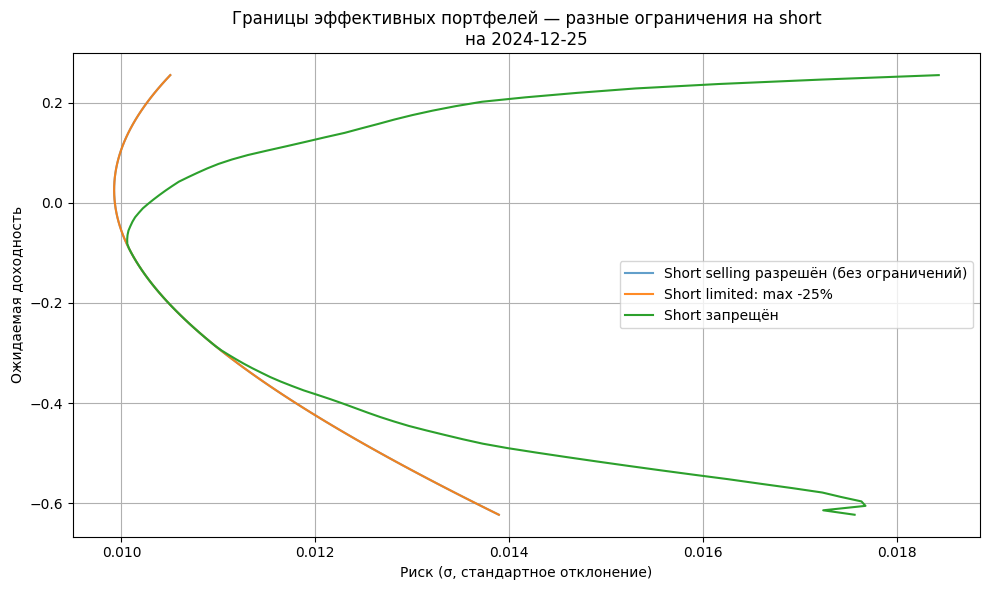

In [10]:
target_returns_noshort = np.linspace(mu.min(), mu.max(), 100)

risks_noshort = []
weights_noshort = []

for R_target in target_returns_noshort:
    def portfolio_variance(w):
        return w.T @ Sigma @ w

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]
    
    # Полный запрет на короткие продажи: все веса от 0 до 1
    bounds = [(0.0, 1.0) for _ in range(n)]

    w0 = np.ones(n) / n

    result = minimize(portfolio_variance, w0, method="SLSQP", bounds=bounds, constraints=constraints)

    if result.success:
        var = result.fun
        std = np.sqrt(var)
        risks_noshort.append(std)
        weights_noshort.append(result.x)
    else:
        risks_noshort.append(np.nan)
        weights_noshort.append(None)

# Визуализация трёх границ вместе
plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns, label="Short selling разрешён (без ограничений)", alpha=0.7)
plt.plot(risks_limited, target_returns_limited, label="Short limited: max -25%", alpha=0.9)
plt.plot(risks_noshort, target_returns_noshort, label="Short запрещён", alpha=1.0)
plt.xlabel("Риск (σ, стандартное отклонение)")
plt.ylabel("Ожидаемая доходность")
plt.title(f"Границы эффективных портфелей — разные ограничения на short\nна {last_date.date()}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Граница: минимум 2% капитала в каждой акции 

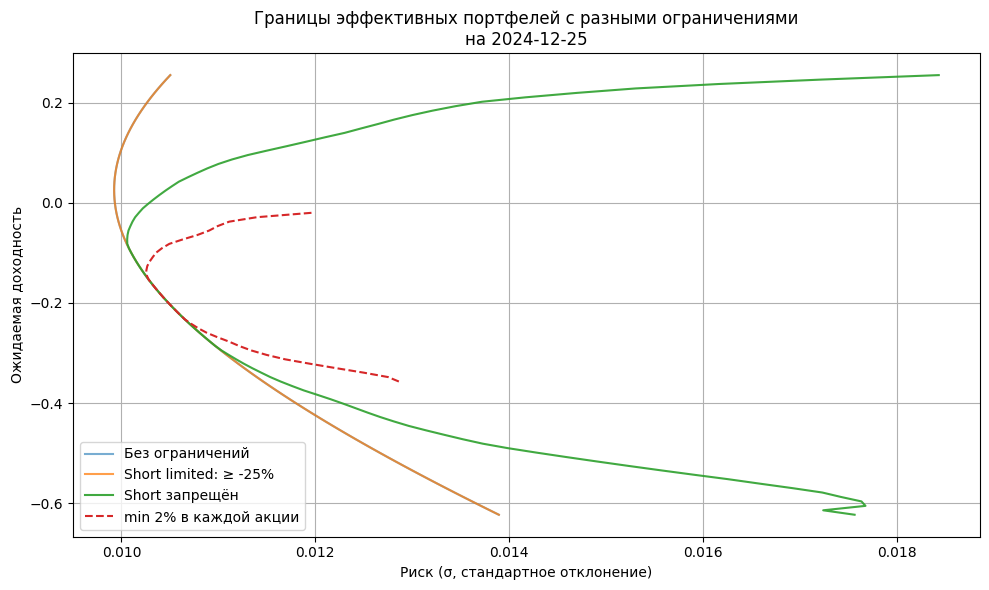

In [11]:
target_returns_min2 = np.linspace(mu.min(), mu.max(), 100)

risks_min2 = []
weights_min2 = []

for R_target in target_returns_min2:
    def portfolio_variance(w):
        return w.T @ Sigma @ w

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]
    
    # Ограничение: минимум 2% капитала в каждой акции
    bounds = [(0.02, 1.0) for _ in range(n)]  

    w0 = np.ones(n) / n  # стартовая точка — равномерное распределение

    result = minimize(portfolio_variance, w0, method="SLSQP", bounds=bounds, constraints=constraints)

    if result.success:
        var = result.fun
        std = np.sqrt(var)
        risks_min2.append(std)
        weights_min2.append(result.x)
    else:
        risks_min2.append(np.nan)
        weights_min2.append(None)

# Визуализация всех 4 границ
plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns, label="Без ограничений", alpha=0.6)
plt.plot(risks_limited, target_returns_limited, label="Short limited: ≥ -25%", alpha=0.75)
plt.plot(risks_noshort, target_returns_noshort, label="Short запрещён", alpha=0.9)
plt.plot(risks_min2, target_returns_min2, label="min 2% в каждой акции", alpha=1.0, linestyle='--')
plt.xlabel("Риск (σ, стандартное отклонение)")
plt.ylabel("Ожидаемая доходность")
plt.title(f"Границы эффективных портфелей с разными ограничениями\nна {last_date.date()}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Динамика границ эффективных портфелей во времени

In [12]:
rolling_frontiers = {}  # ключ: дата, значение: (риски, доходности)

for date_key, cov_matrix in cov_matrices.items():
    try:
        # Доходности за соответствующее окно (252 дня до date_key)
        df_window = df_returns.loc[:date_key].iloc[-252:]
        mu_window = df_window.mean() * 252
        Sigma_window = cov_matrix.values
        mu_arr = mu_window.values
        n_assets = len(mu_arr)

        # Диапазон доходностей
        target_returns_dyn = np.linspace(mu_arr.min(), mu_arr.max(), 50)
        risks_dyn = []

        for R_target in target_returns_dyn:
            def variance(w):
                return w.T @ Sigma_window @ w

            constraints = [
                {"type": "eq", "fun": lambda w: np.sum(w) - 1},
                {"type": "eq", "fun": lambda w: w @ mu_arr - R_target},
            ]
            bounds = [(None, None) for _ in range(n_assets)]
            w0 = np.ones(n_assets) / n_assets

            result = minimize(variance, w0, method="SLSQP", bounds=bounds, constraints=constraints)
            if result.success:
                risks_dyn.append(np.sqrt(result.fun))
            else:
                risks_dyn.append(np.nan)

        rolling_frontiers[date_key] = (risks_dyn, target_returns_dyn)

    except Exception as e:
        print(f"Ошибка на дате {date_key}: {e}")

print(f"Построено границ: {len(rolling_frontiers)}")


Построено границ: 200


# Визуализация нескольких границ 

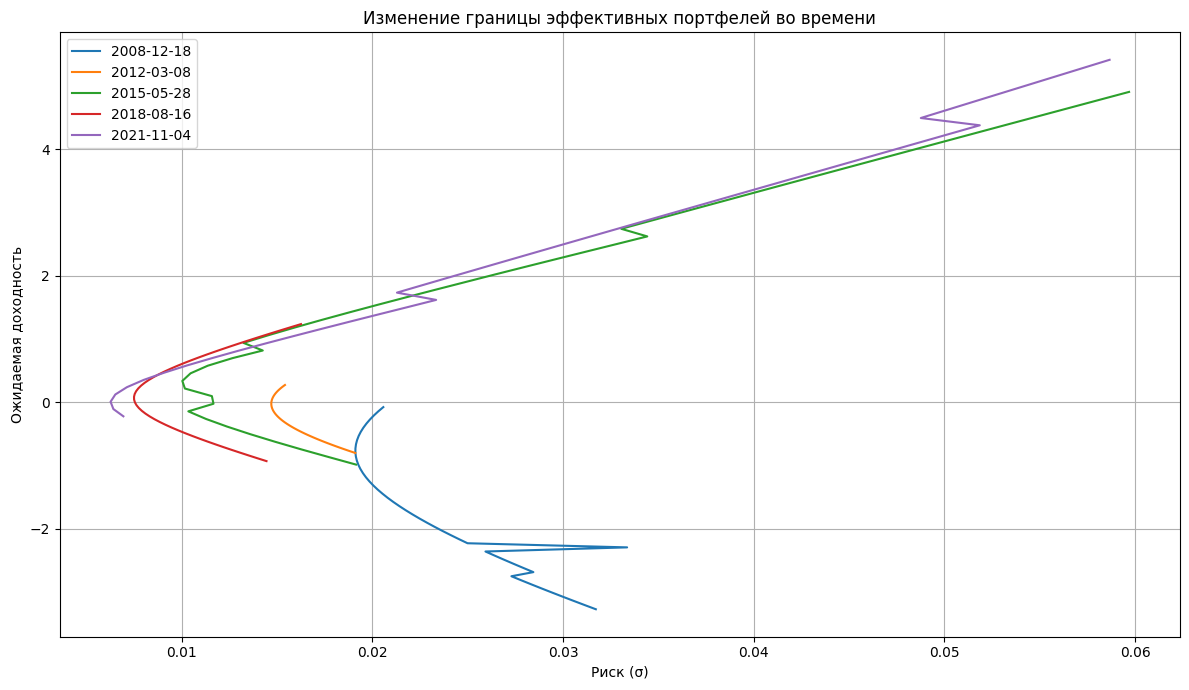

In [13]:
plt.figure(figsize=(12, 7))

# Отрисуем 5 границ с шагом по времени
dates_sorted = sorted(rolling_frontiers.keys())
for i in range(0, len(dates_sorted), max(1, len(dates_sorted) // 5)):
    date = dates_sorted[i]
    risks, rets = rolling_frontiers[date]
    plt.plot(risks, rets, label=f"{date.date()}")

plt.title("Изменение границы эффективных портфелей во времени")
plt.xlabel("Риск (σ)")
plt.ylabel("Ожидаемая доходность")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


- 2008-12-18: Граница начинается с относительно высоким риском и низкой доходностью, что может быть связано с кризисным периодом 2008 года.
- 2012-03-08: Граница становится более плоской, что указывает на снижение риска и доходности в этот период.
- 2015-05-28: Граница снова показывает увеличение риска и доходности.
- 2018-08-16: Граница становится более выпуклой, что может свидетельствовать о росте волатильности рынка.
- 2021-11-04: Граница продолжает расти, демонстрируя увеличение как риска, так и доходности.

# Сравнение границ на ключевые даты 

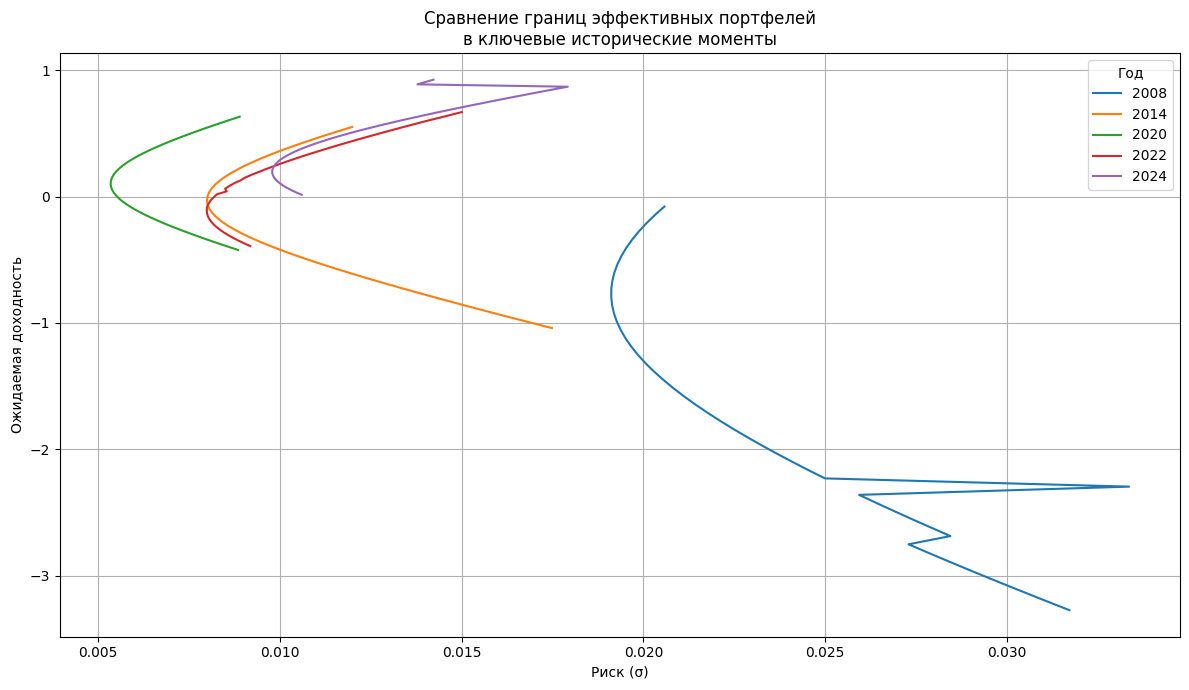

In [14]:
key_years = [2008, 2014, 2020, 2022, 2024]

# Находим ближайшие доступные даты в rolling_frontiers
dates_available = sorted(rolling_frontiers.keys())
selected_dates = []

for year in key_years:
    date_match = next((d for d in dates_available if d.year == year), None)
    if date_match:
        selected_dates.append(date_match)


plt.figure(figsize=(12, 7))

for date in selected_dates:
    risks, rets = rolling_frontiers[date]
    plt.plot(risks, rets, label=f"{date.year}")

plt.title("Сравнение границ эффективных портфелей\nв ключевые исторические моменты")
plt.xlabel("Риск (σ)")
plt.ylabel("Ожидаемая доходность")
plt.grid(True)
plt.legend(title="Год")
plt.tight_layout()
plt.show()


# Оценка входящих данных для optimizer на основе исторических β

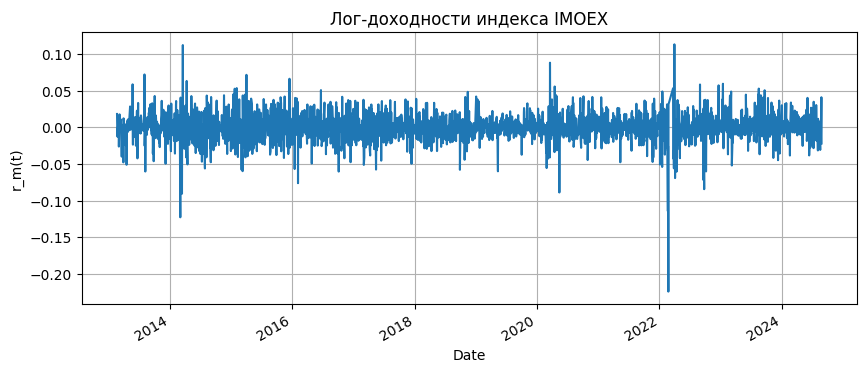

In [15]:
#IMOEX
df_moex = pd.read_csv("MOEX_D1.csv", parse_dates=["datetime"])
df_moex.rename(columns={"datetime": "Date", "close": "IMOEX"}, inplace=True)
df_moex.set_index("Date", inplace=True)
df_moex.sort_index(inplace=True)

#лог-доходности
df_moex["log_return"] = np.log(df_moex["IMOEX"] / df_moex["IMOEX"].shift(1))
df_moex = df_moex.dropna()

df_moex["log_return"].plot(figsize=(10, 4), title="Лог-доходности индекса IMOEX")
plt.ylabel("r_m(t)")
plt.grid(True)
plt.show()


Используем общую последнюю дату: 2024-08-27
Синхронизировано: 251 дней
Окно по акциям: (251, 30)
Окно по индексу: (251,)


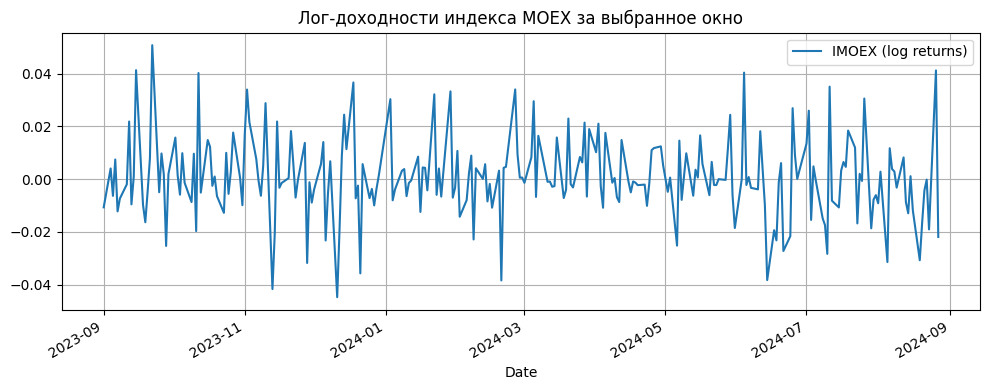

In [22]:
# Лог-доходностей по акциям
df_returns = pd.read_csv("df_log_returns.csv", index_col="Date", parse_dates=True)

# IMOEX 
df_moex = pd.read_csv("MOEX_D1.csv", parse_dates=["datetime"])
df_moex.rename(columns={"datetime": "Date", "close": "IMOEX"}, inplace=True)
df_moex.set_index("Date", inplace=True)
df_moex.sort_index(inplace=True)

# Лог-доходность MOEX
df_moex["log_return"] = np.log(df_moex["IMOEX"] / df_moex["IMOEX"].shift(1))
df_moex.dropna(inplace=True)

# Синхронизация: определим максимально возможную общую дату 
last_date = min(df_moex.index.max(), df_returns.index.max())
print(f"Используем общую последнюю дату: {last_date.date()}")

# Выбор 252-дневного окна для рынка и активов

r_m = df_moex.loc[:last_date].iloc[-252:]["log_return"]

# Находим пересечение индексов
common_dates = df_returns.index.intersection(r_m.index)

# Перестраиваем r_m и df_assets_window только по общим датам
r_m = r_m.loc[common_dates]
df_assets_window = df_returns.loc[common_dates]

print(f"Синхронизировано: {df_assets_window.shape[0]} дней")
print(f"Окно по акциям: {df_assets_window.shape}")
print(f"Окно по индексу: {r_m.shape}")


plt.figure(figsize=(10, 4))
r_m.plot(label="IMOEX (log returns)")
plt.title("Лог-доходности индекса MOEX за выбранное окно")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
betas = []
residual_vars = []

r_m_array = r_m.values  
tickers = df_assets_window.columns

for ticker in tickers:
    r_i = df_assets_window[ticker].values

    mask = ~np.isnan(r_i) & ~np.isnan(r_m_array)

    x = r_m_array[mask]
    y = r_i[mask]

    if len(x) > 10:  
        # Расчёт β по формуле ковариации и дисперсии
        cov_im = np.cov(y, x, ddof=1)[0, 1]
        var_m = np.var(x, ddof=1)
        beta = cov_im / var_m

        # Остатки и их дисперсия
        y_hat = beta * x
        residuals = y - y_hat
        residual_var = np.var(residuals, ddof=1)
    else:
        beta = np.nan
        residual_var = np.nan

    betas.append(beta)
    residual_vars.append(residual_var)

beta_vec = np.array(betas)
residual_var_vec = np.array(residual_vars)
market_var = np.var(r_m_array, ddof=1)

# Ковариационная матрица по модели рынка
cov_market_model = np.outer(beta_vec, beta_vec) * market_var + np.diag(residual_var_vec)
cov_market_model_df = pd.DataFrame(cov_market_model, index=tickers, columns=tickers)

cov_market_model_df.to_csv("cov_matrix_historical_betas.csv")
print("✅ Ковариационная матрица по historical β")


✅ Ковариационная матрица по historical β


In [31]:
cov_market_model_df

,TRMK,PLZL,SBER,ROSN,TATN,TTLK,UTAR,KMAZ,LSRG,MTSS,...,GAZP,NVTK,SNGS,TRNFP,AFLT,VTBR,CHMF,PIKK,NMTP,MGNT
TRMK,0.000531,0.000029,0.000030,0.000036,0.000033,0.000049,0.000035,0.000063,0.000040,0.000036,...,0.000035,0.000041,0.000057,0.000037,0.000056,0.000040,0.000064,0.000035,0.000075,0.000048
PLZL,0.000029,0.000290,0.000015,0.000018,0.000016,0.000024,0.000017,0.000030,0.000020,0.000017,...,0.000017,0.000020,0.000028,0.000018,0.000027,0.000020,0.000031,0.000017,0.000037,0.000023
SBER,0.000030,0.000015,0.000134,0.000018,0.000017,0.000025,0.000018,0.000032,0.000020,0.000018,...,0.000017,0.000021,0.000029,0.000019,0.000028,0.000020,0.000032,0.000018,0.000038,0.000024
ROSN,0.000036,0.000018,0.000018,0.000208,0.000020,0.000030,0.000021,0.000038,0.000024,0.000022,...,0.000021,0.000025,0.000034,0.000022,0.000034,0.000025,0.000039,0.000021,0.000046,0.000029
TATN,0.000033,0.000016,0.000017,0.000020,0.000188,0.000027,0.000019,0.000034,0.000022,0.000020,...,0.000019,0.000023,0.000031,0.000020,0.000031,0.000022,0.000035,0.000019,0.000041,0.000026
TTLK,0.000049,0.000024,0.000025,0.000030,0.000027,0.001477,0.000029,0.000051,0.000033,0.000029,...,0.000028,0.000034,0.000046,0.000030,0.000046,0.000033,0.000052,0.000029,0.000061,0.000039
UTAR,0.000035,0.000017,0.000018,0.000021,0.000019,0.000029,0.001069,0.000037,0.000024,0.000021,...,0.000020,0.000024,0.000033,0.000022,0.000033,0.000024,0.000038,0.000021,0.000044,0.000028
KMAZ,0.000063,0.000030,0.000032,0.000038,0.000034,0.000051,0.000037,0.000544,0.000042,0.000037,...,0.000036,0.000043,0.000059,0.000038,0.000059,0.000042,0.000067,0.000037,0.000079,0.000050
LSRG,0.000040,0.000020,0.000020,0.000024,0.000022,0.000033,0.000024,0.000042,0.000649,0.000024,...,0.000023,0.000028,0.000038,0.000025,0.000038,0.000027,0.000043,0.000024,0.000051,0.000032
MTSS,0.000036,0.000017,0.000018,0.000022,0.000020,0.000029,0.000021,0.000037,0.000024,0.000278,...,0.000021,0.000025,0.000034,0.000022,0.000034,0.000024,0.000038,0.000021,0.000045,0.000028


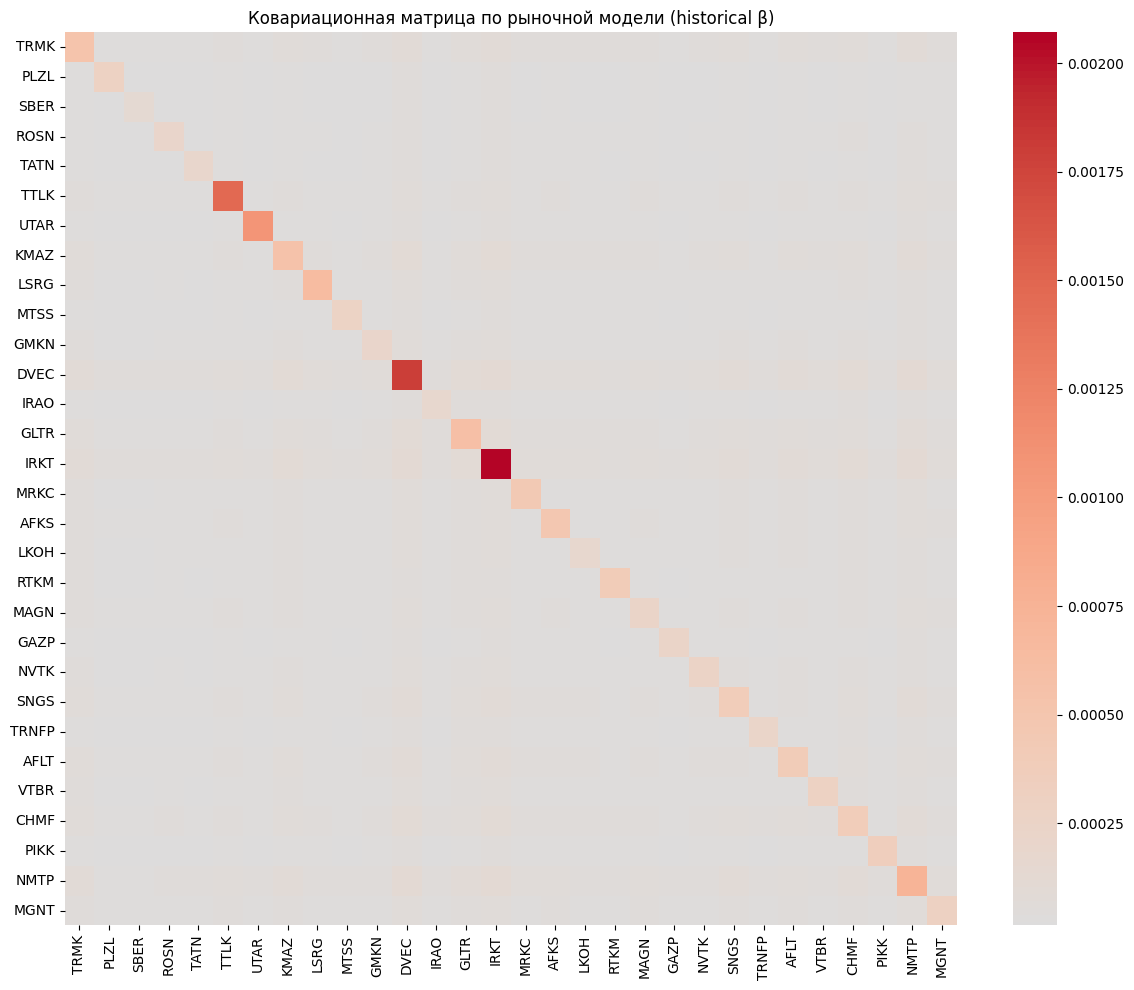

In [30]:
plt.figure(figsize=(12, 10))
sns.heatmap(cov_market_model_df, cmap="coolwarm", center=0)
plt.title("Ковариационная матрица по рыночной модели (historical β)")
plt.tight_layout()
plt.show()


# Построение границы эффективных портфелей на основе ковариационной матрицы по историческим β

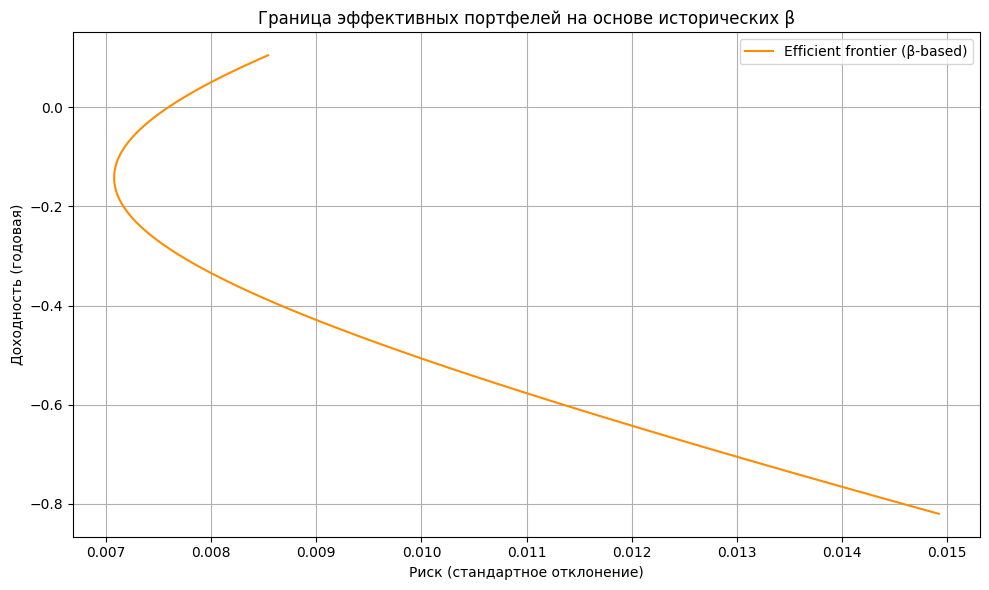

In [32]:
tickers = cov_market_model_df.columns
mu = df_assets_window.mean().values * 252  # годовые средние доходности
Sigma = cov_market_model_df.values
n = len(tickers)

# Диапазон целевых доходностей
target_returns_beta = np.linspace(mu.min(), mu.max(), 100)

risks_beta = []
weights_beta = []

for R_target in target_returns_beta:
    def portfolio_variance(w):
        return w.T @ Sigma @ w

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]

    bounds = [(None, None) for _ in range(n)]  # short-selling разрешен
    w0 = np.ones(n) / n  # стартовая точка

    result = minimize(portfolio_variance, w0, method="SLSQP", bounds=bounds, constraints=constraints)

    if result.success:
        std = np.sqrt(result.fun)
        risks_beta.append(std)
        weights_beta.append(result.x)
    else:
        risks_beta.append(np.nan)
        weights_beta.append(None)

plt.figure(figsize=(10, 6))
plt.plot(risks_beta, target_returns_beta, label="Efficient frontier (β-based)", color="darkorange")
plt.xlabel("Риск (стандартное отклонение)")
plt.ylabel("Доходность (годовая)")
plt.title("Граница эффективных портфелей на основе исторических β")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Оценка входящих данных для optimizer на основе скорректированных β

In [35]:
# Расчёт скорректированных (adjusted) β
beta_adj_vec = 0.67 * beta_vec + 0.33 * 1  # сдвиг к 1

cov_adjusted_model = np.outer(beta_adj_vec, beta_adj_vec) * market_var + np.diag(residual_var_vec)
cov_adjusted_df = pd.DataFrame(cov_adjusted_model, index=tickers, columns=tickers)

cov_adjusted_df.to_csv("cov_matrix_adjusted_betas.csv")
print("✅ Ковариационная матрица по скорректированным β сохранена.")

✅ Ковариационная матрица по скорректированным β сохранена.


In [37]:
cov_adjusted_df

,TRMK,PLZL,SBER,ROSN,TATN,TTLK,UTAR,KMAZ,LSRG,MTSS,...,GAZP,NVTK,SNGS,TRNFP,AFLT,VTBR,CHMF,PIKK,NMTP,MGNT
TRMK,0.000575,0.000077,0.000078,0.000083,0.000080,0.000094,0.000082,0.000106,0.000087,0.000082,...,0.000081,0.000087,0.000101,0.000083,0.000101,0.000087,0.000108,0.000082,0.000117,0.000093
PLZL,0.000077,0.000333,0.000057,0.000061,0.000059,0.000070,0.000061,0.000078,0.000064,0.000061,...,0.000060,0.000065,0.000075,0.000062,0.000074,0.000064,0.000079,0.000061,0.000087,0.000069
SBER,0.000078,0.000057,0.000177,0.000062,0.000060,0.000070,0.000061,0.000079,0.000065,0.000062,...,0.000061,0.000065,0.000076,0.000062,0.000075,0.000065,0.000080,0.000061,0.000088,0.000070
ROSN,0.000083,0.000061,0.000062,0.000253,0.000064,0.000075,0.000066,0.000085,0.000069,0.000066,...,0.000065,0.000070,0.000081,0.000067,0.000081,0.000069,0.000086,0.000066,0.000094,0.000075
TATN,0.000080,0.000059,0.000060,0.000064,0.000232,0.000073,0.000063,0.000082,0.000067,0.000063,...,0.000063,0.000067,0.000078,0.000064,0.000078,0.000067,0.000083,0.000063,0.000090,0.000072
TTLK,0.000094,0.000070,0.000070,0.000075,0.000073,0.001522,0.000074,0.000096,0.000078,0.000075,...,0.000074,0.000079,0.000092,0.000076,0.000091,0.000079,0.000097,0.000074,0.000106,0.000084
UTAR,0.000082,0.000061,0.000061,0.000066,0.000063,0.000074,0.001113,0.000084,0.000068,0.000065,...,0.000064,0.000069,0.000080,0.000066,0.000080,0.000068,0.000085,0.000065,0.000093,0.000074
KMAZ,0.000106,0.000078,0.000079,0.000085,0.000082,0.000096,0.000084,0.000587,0.000089,0.000084,...,0.000083,0.000090,0.000103,0.000085,0.000103,0.000089,0.000110,0.000084,0.000120,0.000095
LSRG,0.000087,0.000064,0.000065,0.000069,0.000067,0.000078,0.000068,0.000089,0.000694,0.000069,...,0.000068,0.000073,0.000084,0.000070,0.000084,0.000072,0.000090,0.000068,0.000098,0.000078
MTSS,0.000082,0.000061,0.000062,0.000066,0.000063,0.000075,0.000065,0.000084,0.000069,0.000323,...,0.000065,0.000069,0.000080,0.000066,0.000080,0.000069,0.000085,0.000065,0.000093,0.000074


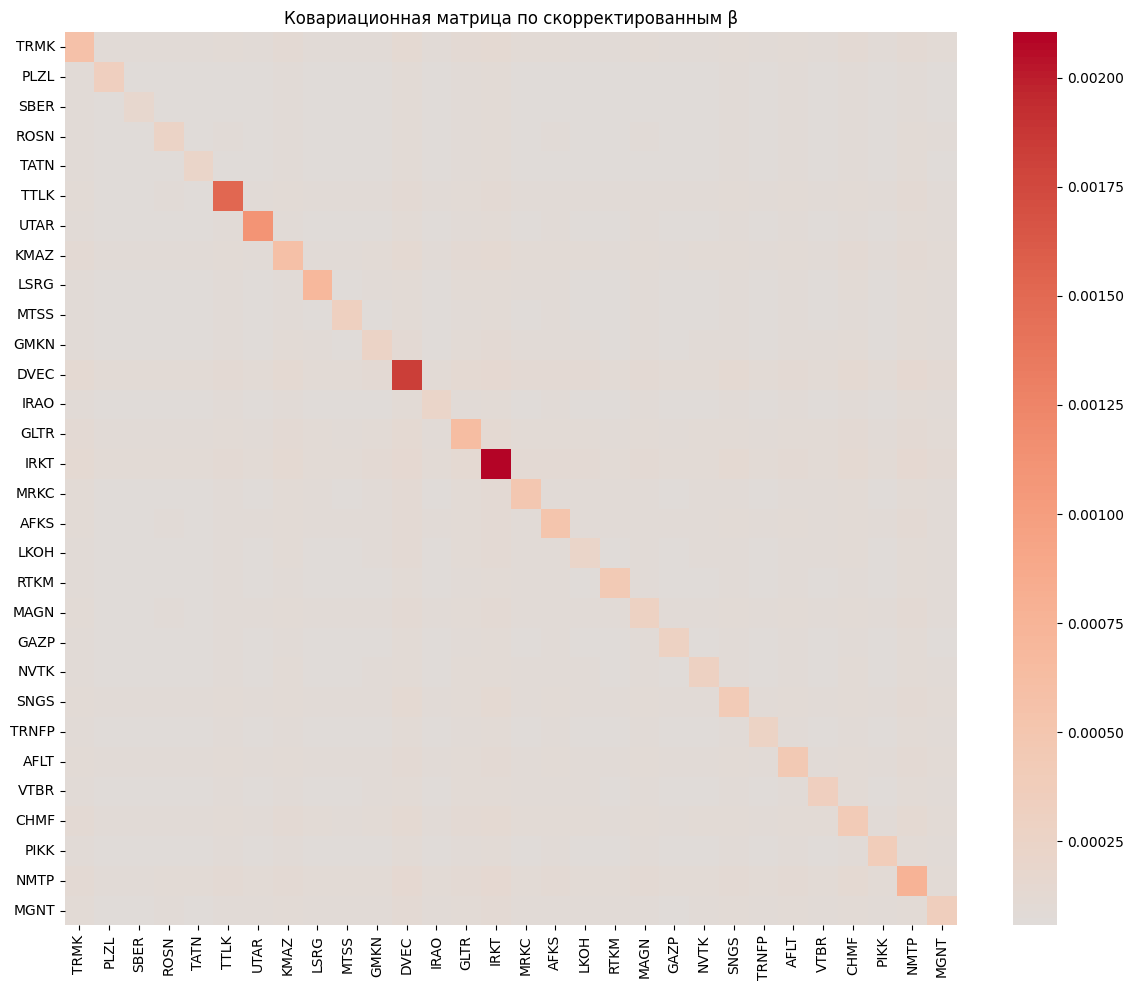

In [36]:
plt.figure(figsize=(12, 10))
sns.heatmap(cov_adjusted_df, cmap="coolwarm", center=0)
plt.title("Ковариационная матрица по скорректированным β")
plt.tight_layout()
plt.show()

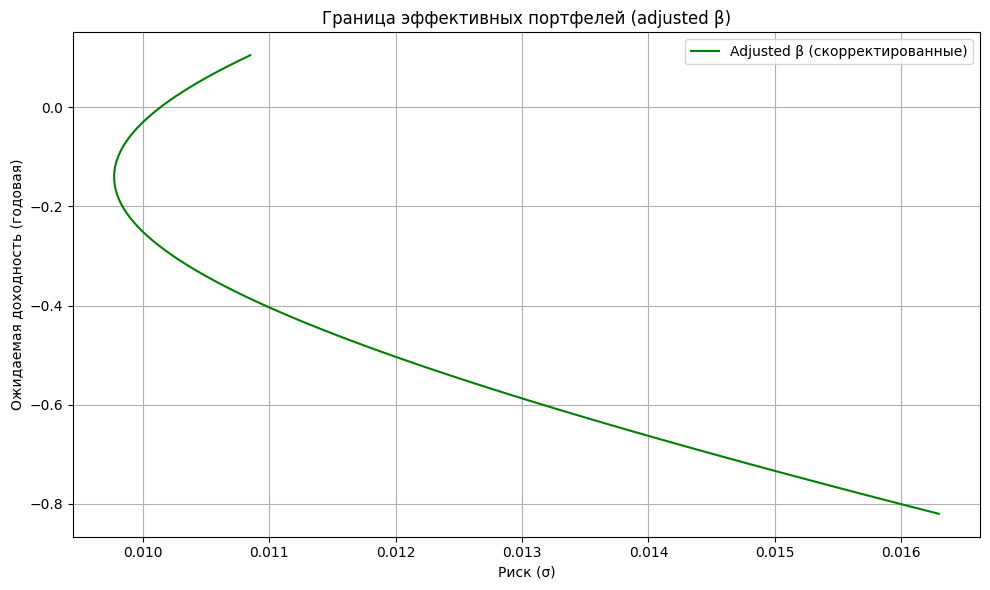

In [38]:
Sigma_adj = cov_adjusted_df.values
n = len(mu)

# Диапазон доходностей
target_returns_adj = np.linspace(mu.min(), mu.max(), 100)

risks_adj = []
weights_adj = []

for R_target in target_returns_adj:
    def portfolio_variance(w):
        return w.T @ Sigma_adj @ w

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]

    bounds = [(None, None) for _ in range(n)]  # short-selling разрешён
    w0 = np.ones(n) / n

    result = minimize(portfolio_variance, w0, method="SLSQP", bounds=bounds, constraints=constraints)

    if result.success:
        std = np.sqrt(result.fun)
        risks_adj.append(std)
        weights_adj.append(result.x)
    else:
        risks_adj.append(np.nan)
        weights_adj.append(None)

plt.figure(figsize=(10, 6))
plt.plot(risks_adj, target_returns_adj, label="Adjusted β (скорректированные)", color="green")
plt.xlabel("Риск (σ)")
plt.ylabel("Ожидаемая доходность (годовая)")
plt.title("Граница эффективных портфелей (adjusted β)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Сравнение границ эффективных портфелей

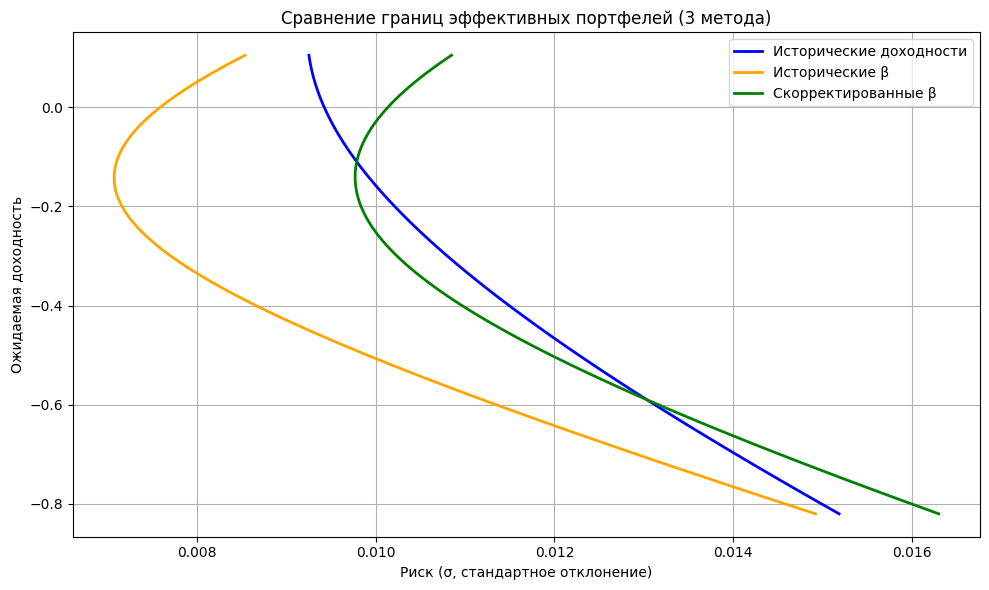

In [45]:
# mu — вектор средних годовых доходностей (уже посчитан ранее)
# cov_matrix (историческая)
# cov_market_model_df (historical beta)
# cov_adjusted_df (adjusted beta)
# tickers — список тикеров

n = len(mu)

# Историческая ковариация
target_returns = []
risks = []

for R_target in np.linspace(mu.min(), mu.max(), 100):
    def portfolio_var(w): return w.T @ cov_matrix @ w
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]
    result = minimize(portfolio_var, np.ones(n)/n, method='SLSQP', bounds=[(None, None)]*n, constraints=constraints)
    if result.success:
        risks.append(np.sqrt(result.fun))
        target_returns.append(R_target)

# Исторические β 
target_returns_beta = []
risks_beta = []

Sigma_beta = cov_market_model_df.values

for R_target in np.linspace(mu.min(), mu.max(), 100):
    def portfolio_var(w): return w.T @ Sigma_beta @ w
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]
    result = minimize(portfolio_var, np.ones(n)/n, method='SLSQP', bounds=[(None, None)]*n, constraints=constraints)
    if result.success:
        risks_beta.append(np.sqrt(result.fun))
        target_returns_beta.append(R_target)

# Adjusted β 
target_returns_adj = []
risks_adj = []

Sigma_adj = cov_adjusted_df.values

for R_target in np.linspace(mu.min(), mu.max(), 100):
    def portfolio_var(w): return w.T @ Sigma_adj @ w
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: w @ mu - R_target},
    ]
    result = minimize(portfolio_var, np.ones(n)/n, method='SLSQP', bounds=[(None, None)]*n, constraints=constraints)
    if result.success:
        risks_adj.append(np.sqrt(result.fun))
        target_returns_adj.append(R_target)

plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns, label="Исторические доходности", color="blue", linewidth=2)
plt.plot(risks_beta, target_returns_beta, label="Исторические β", color="orange", linewidth=2)
plt.plot(risks_adj, target_returns_adj, label="Скорректированные β", color="green", linewidth=2)
plt.xlabel("Риск (σ, стандартное отклонение)")
plt.ylabel("Ожидаемая доходность")
plt.title("Сравнение границ эффективных портфелей (3 метода)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
